In [20]:
using DIVAnd
using PyPlot
using PyCall
using Dates
using DelimitedFiles

In [101]:
ccrs = pyimport("cartopy.crs")
gridliner = pyimport("cartopy.mpl.gridliner")
cfeature = pyimport("cartopy.feature")
mticker = pyimport("matplotlib.ticker")
myproj = ccrs.PlateCarree()
coast = cfeature.GSHHSFeature(scale="intermediate");
mpl = pyimport("matplotlib");
cartopyticker = pyimport("cartopy.mpl.ticker")
lon_formatter = cartopyticker.LongitudeFormatter()
lat_formatter = cartopyticker.LatitudeFormatter()
mpl.rc("axes", linewidth=2)
mpl.rc("font", weight="light", size=14)

In [102]:
function decorate_map(ax)
    PyPlot.grid(linewidth=0.2)
    ax.add_feature(coast, color=".6", 
            edgecolor="k", zorder=5)
    ax.set_xticks(-180.:45.5:180.)
    ax.set_yticks(-90.:30:90.) 
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

end

decorate_map (generic function with 1 method)

In [93]:
datadir = "./data/"
figdir = "./figures"
if !isdir(figdir)
    mkdir(figdir)
end
datafile = joinpath(datadir, "data.csv")
@info(isfile(datafile));

┌ Info: true
└ @ Main In[93]:7


## Read data

In [134]:
data, columnnames = readdlm(datafile, ',', header=true);
@info(columnnames);

┌ Info: AbstractString["" "id" "occurrenceID" "eventDate" "decimalLatitude" "decimalLongitude" "geodeticDatum" "minimumDepthInMeters" "maximumDepthInMeters" "scientificName" "scientificNameID" "individualCount" "sampleSizeValue" "aphiaID" "abundance" "abundanceUnit" "abundanceMeasurementTypeID" "abundanceMeasurementUnitID" "logAbundance"]
└ @ Main In[134]:2


### Extract coordinates

In [95]:
lat_index = findall(columnnames .== "decimalLatitude");
lat = data[:,5];
lon = data[:,6];
dates = data[:,4];

In [136]:
scientificNames = data[:,10];
namelist = unique(scientificNames)

6-element Array{Any,1}:
 "Metridia lucens"
 "Calanus finmarchicus"
 "Oithona"
 "Temora longicornis"
 "Acartia"
 "Calanus helgolandicus"

### Parse dates

In [107]:
dates0 = dates[1]
df = DateFormat("y-m-d H:M:S.s");
dt = DateTime(dates0, df)

2017-03-13T02:50:00

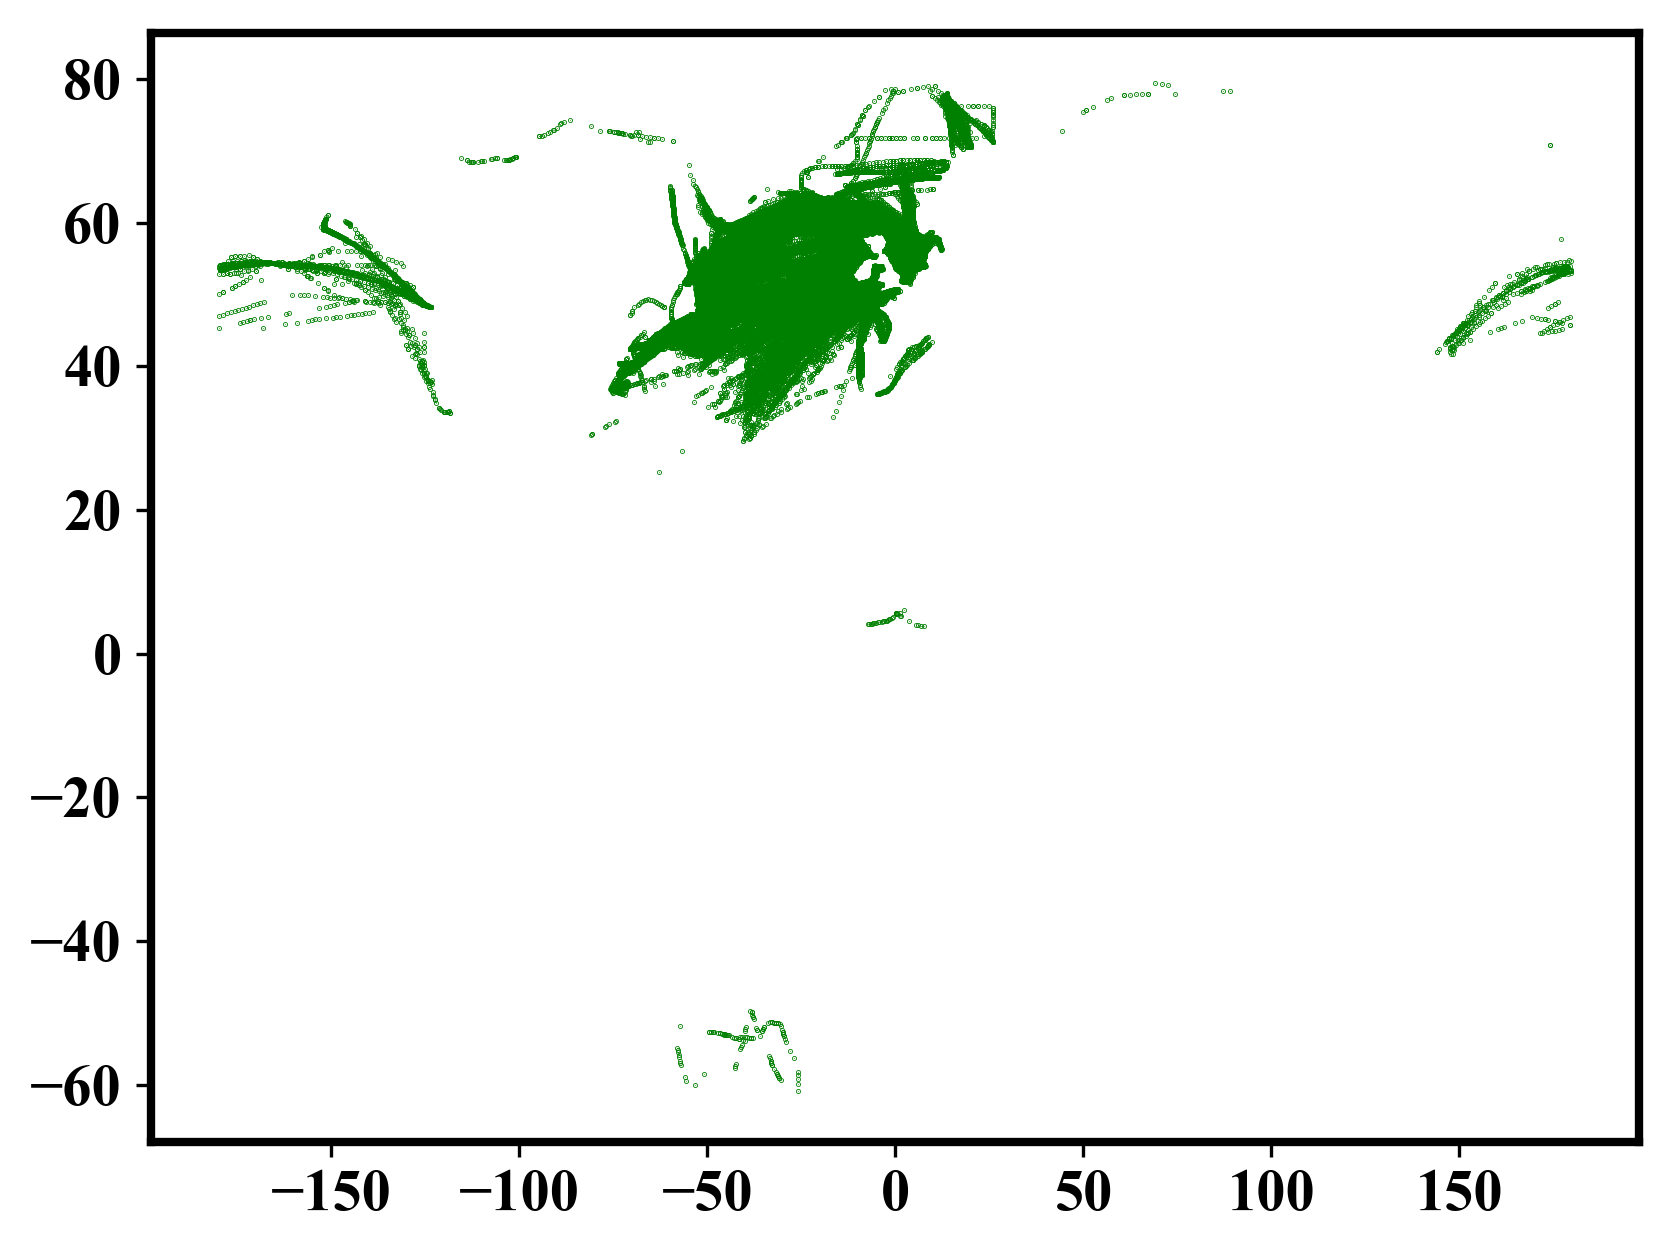

In [110]:
PyPlot.plot(lon, lat, "go", markersize=0.2)
PyPlot.savefig(joinpath(figdir, "data_distrib"), dpi=300, bbox_inches="tight")

### Using Cartopy

In [111]:
fig = PyPlot.figure(figsize=(12, 15))
ax = PyPlot.subplot(111, projection=myproj)
ax.plot(lon, lat, "go", markersize=0.2)
decorate_map(ax)
PyPlot.savefig(joinpath(figdir, "data_distrib02"), dpi=300, bbox_inches="tight")
PyPlot.close()

### By species

In [140]:
for names in namelist
    gooddata = findall(scientificNames .== names)
    @info("Found $(length(gooddata)) data points for $(names)")
end

┌ Info: Found 44353 data points for Metridia lucens
└ @ Main In[140]:3
┌ Info: Found 86486 data points for Calanus finmarchicus
└ @ Main In[140]:3
┌ Info: Found 66761 data points for Oithona
└ @ Main In[140]:3
┌ Info: Found 43416 data points for Temora longicornis
└ @ Main In[140]:3
┌ Info: Found 66328 data points for Acartia
└ @ Main In[140]:3
┌ Info: Found 59034 data points for Calanus helgolandicus
└ @ Main In[140]:3


In [114]:
longrid = -90.:1.:40.
latgrid = 30.:1.:80.

30.0:1.0:80.0

## Bathymetry

In [119]:
bathname = joinpath(datadir, "gebco_30sec_16.nc")

"./data/gebco_30sec_16.nc"

In [115]:
if !isfile(bathname)
    @info("Download bathymetry")
    download("https://dox.ulg.ac.be/index.php/s/U0pqyXhcQrXjEUX/download",bathname)
else
    @info("Bathymetry file already downloaded")
end

┌ Info: Download bathymetry
└ @ Main In[115]:3


"./data/gebco_30sec_8.nc"

In [120]:
bx, by, b = load_bath(bathname, true, longrid, latgrid);

(-90.0:1.0:40.0, 30.0:1.0:80.0, [-1.767578125216506 -95.06054687370558 … -558.2675781704319 -554.9345703256138; 4.2675781248658815 -64.3867187497123 … -1369.7070312153196 -212.92187500138212; … ; -595.8183593791433 -846.6953125036256 … 206.16796874504644 242.4824218803826; -676.1337890525585 -814.8046874987749 … 184.03906249955213 314.14062500161094])

In [129]:
fig = PyPlot.figure(figsize=(10, 10))
ax = PyPlot.subplot(111, projection=myproj)
pcm = ax.pcolor(bx, by, b'); 
colorbar(pcm, orientation="vertical", shrink=0.35)
PyPlot.title("Bathymetry")
PyPlot.savefig(joinpath(figdir, "domain_bathymetry"), dpi=300, bbox_inches="tight")
PyPlot.close()

### Metrics

In [133]:
_, (pm,pn), (xi,yi) = DIVAnd.DIVAnd_rectdom(longrid, latgrid);

### Land-sea mask

In [127]:
xmask, ymask, mmask = load_mask(bathname, true, longrid, latgrid, 0.0);

In [132]:
fig = PyPlot.figure(figsize=(10, 10))
ax = PyPlot.subplot(111, projection=myproj)
pcm = ax.pcolor(bx, by, transpose(mmask), cmap=PyPlot.cm.binary_r); 
PyPlot.title("Land-sea mask")
PyPlot.savefig(joinpath(figdir, "domain_landsea_mask"), dpi=300, bbox_inches="tight")
PyPlot.close()

## DIVAnd interpolation